notes on 2019.12.23:
1. statistics of radar data
2. pick rainny cases for testing
- Build datasets (2 images for OF, 12 images for AD). Select data that is  rainy region >10% for at least 2 hours.  One year is 365x24 = 8544 hours or 102 k images, prepare at least 10 k pair of samples to test.
- Compare 3 approaches, Du original, rainy motion, pysteps. Metrics is CSI and computation speed.  The goal is acheive CSI > 0.5 in 1 hour lead time forecast for a threshold of 1 mm/h

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

data_folder = "/Users/jiang/data/radar20190101"
grib_files = glob.glob(os.path.join(data_folder,"*.000"))  # 288 = 12*24
grib_files.sort()

/Users/jiang/github_all/rainymotion/docs/notebooks


In [22]:
var = "surface"
for grib_file in grib_files:
    ncfile = grib_file.split(".")[0]+".nc"
    cmd = f"wgrib2 {grib_file} -s | egrep '({var})'|wgrib2 -i {grib_file} -netcdf {ncfile}"
    fail = os.system(cmd)  # 0 indicate success, others indicate fail
    if fail:
        print("wgrib2 wrong at ",grib_file)

In [4]:
from netCDF4 import Dataset
nc_file = "/Users/jiang/data/radar20190101/20190101_000000.nc"
root = Dataset(nc_file, "r")

In [9]:
from datetime import datetime,timedelta
dt = datetime(1970, 1, 1) + timedelta(seconds = root['time'][0].compressed()[0])
date_string = dt.strftime('%Y-%m-%d %H:%M UTC ')
print(date_string)

2019-01-01 00:00 UTC 


In [5]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [94]:
honshu_rain = []
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled().astype('float16')
    honshu_rain.append(np.sum(rain_filled >= 1)/1e6)

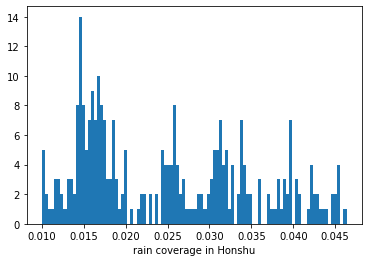

In [99]:
plt.hist(honshu_rain,100)
plt.xlabel("rain coverage in Honshu")
plt.show()

## test rainymotion dense mode

In [7]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import wradlib.ipol as ipol
%matplotlib inline
from netCDF4 import Dataset

In [ ]:
nc_files = glob.glob(os.path.join(data_folder,"*.nc"))  # 288 = 12*24
nc_files.sort()

In [12]:
all_data = []
for nc_file in nc_files:
    root = Dataset(nc_file, "r")
    rain = root['var0_1_203_surface'][0,:,:] # masked array, shape(3360,3560)
    rain_reduced = rain[1500:2500,1000:2000].copy()
    rain_reduced.fill_value = 0.0
    rain_filled = rain_reduced.filled()
    all_data.append(rain_filled) 

In [20]:
inputs = np.array([all_data[0],all_data[1]])

In [51]:
model = models.SparseSD()
model.input_data = inputs
nowcast = model.run()  # shape (12, 900, 900)

sparse_12 = []
for i in range (12):
    sparse_12.append(metrics.CSI(all_data[2+i],nowcast[0+i], threshold = 1))

In [52]:
model = models.Dense()
model.input_data = inputs
nowcast = model.run()  # shape (12, 900, 900)
dense_12 = []
for i in range (12):
    dense_12.append(metrics.CSI(all_data[2+i],nowcast[0+i], threshold = 1))

In [53]:
persist_12 = []
for i in range (12):
    persist_12.append(metrics.CSI(all_data[2+i],all_data[1], threshold = 1))

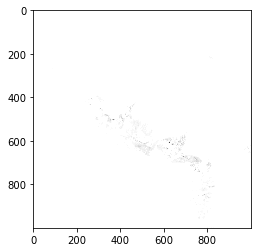

In [60]:
plt.imshow(all_data[13], cmap= "gray_r")

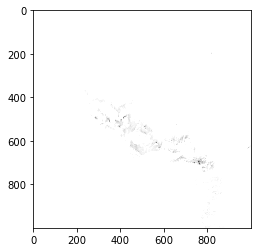

In [58]:
plt.imshow(nowcast[11], cmap= "gray_r")

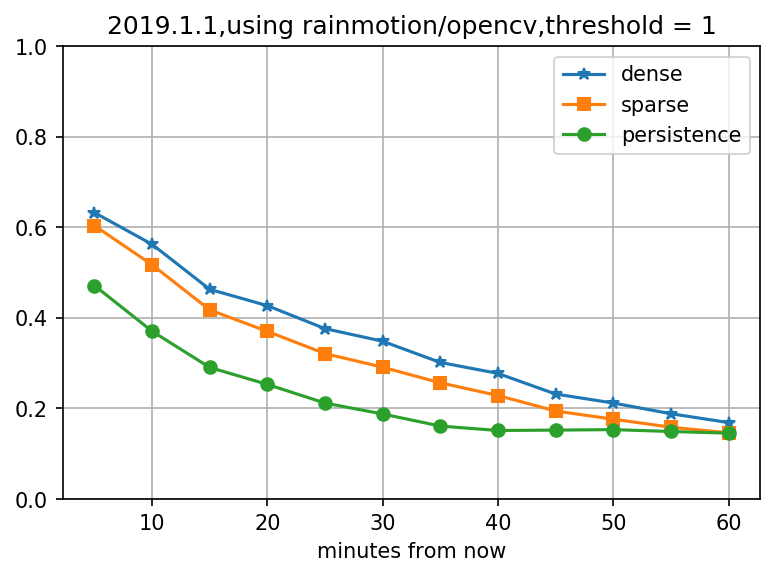

In [57]:
plt.figure(dpi=150)
plt.plot(list(range(5,65,5)), dense_12, '-*', label = "dense")
plt.plot(list(range(5,65,5)), sparse_12, '-s',label = "sparse")
plt.plot(list(range(5,65,5)), persist_12, '-o',label = "persistence")
plt.legend()
plt.ylim([0,1])
plt.xlabel("minutes from now")
plt.title("2019.1.1,using rainmotion/opencv,threshold = 1")
plt.grid()
plt.show()